In [1]:
from MVT_funcyz import GRBS_in_folder, print_banner
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import spearmanr
from scipy.optimize import curve_fit

In [2]:
# dictionary for axis names in plots
name_dict = {
    'T90_duration': '$T_{90}$ (s)',
    'Tpre_duration': '$T_{pre}$ (s)',
    'T90_MVT': '$MVT_{90}$ (s)',
    'Tpre_MVT': '$MVT_{pre}$ (s)',
}

In [3]:
def plotter(df, x_axis, y_axis, yerror, log=False):

    mpl.rcParams['font.size'] = 15
    xlabel = x_axis.split('_')
    ylabel = y_axis.split('_')

    plt.figure(figsize=(8, 6))
    plt.errorbar(df[x_axis], df[y_axis], yerr= df[yerror], marker='o', linestyle='', color='black', markersize=2, capsize=2)
    plt.xlabel('$T_{%s}$ %s' % (xlabel[0][1:], xlabel[1]))
    plt.ylabel('$T_{%s}$ %s' % (ylabel[0][1:], ylabel[1]))

    if log:
        plt.xscale('log')
        plt.yscale('log')

    plt.show()

In [4]:
def hplotter(df, x_axis, y_axis, xerror=None, yerror=None, log=False, best_fit=False, save=False):

    def func(x, a, b):
        return a * x + b

    df1 = df[[x_axis, y_axis]].dropna()
    x = np.log10(df1[x_axis]) if log else df1[x_axis]
    y = np.log10(df1[y_axis]) if log else df1[y_axis]
    popt, pcov = curve_fit(func, x, y)
    correlation, p_value = spearmanr(df1[x_axis], df1[y_axis])
    gradient_error = np.sqrt(np.diag(pcov))[0]
    print(f"Gradient of the best fit line: {popt[0]} +/- {gradient_error}")
    print(f'Correlation: {correlation}, p-value: {p_value}')


    defo_short_df  = df[(df['Sample'] == 'KN')]
    anoms_df  = df[(df['Sample'] == 'Anomalies')]
    t_shorts_df = df[(df['Sample'] != 'KN') & (df['Sample'] != 'Anomalies') & (df['T90_duration'] <= 2)]
    defo_longs_df = df[(df['Sample'] == 'Cano')]
    t_longs_df = df[(df['Sample'] != 'Cano') & (df['Sample'] != 'Anomalies') & (df['T90_duration'] > 2)]

    mrksz = 6
    mpl.rcParams['font.size'] = 17
    plt.figure(figsize=(8, 6))

    plt.errorbar(defo_short_df[x_axis], defo_short_df[y_axis], xerr=(defo_short_df[xerror] if xerror is not None else 0), yerr=(defo_short_df[yerror] if yerror is not None else 0), marker='s', linestyle='', color='red', markersize=mrksz, capsize=2, markerfacecolor='none', elinewidth=1)
    plt.errorbar(anoms_df[x_axis], anoms_df[y_axis], xerr=(anoms_df[xerror] if xerror is not None else 0), yerr=(anoms_df[yerror] if yerror is not None else 0), marker='s', linestyle='', color='green', markersize=mrksz, capsize=(2 if (yerror is not None or xerror is not None) else 0), markerfacecolor='none', elinewidth=1)
    plt.errorbar(t_shorts_df[x_axis], t_shorts_df[y_axis], xerr=(t_shorts_df[xerror] if xerror is not None else 0), yerr=(t_shorts_df[yerror] if yerror is not None else 0), marker='o', linestyle='', color='red', markersize=4, capsize=2, elinewidth=1)
    plt.errorbar(defo_longs_df[x_axis], defo_longs_df[y_axis], xerr=(defo_longs_df[xerror] if xerror is not None else 0), yerr=(defo_longs_df[yerror] if yerror is not None else 0), marker='s', linestyle='', color='blue', markersize=mrksz, capsize=2, markerfacecolor='none', elinewidth=1)
    plt.errorbar(t_longs_df[x_axis], t_longs_df[y_axis], xerr=(t_longs_df[xerror] if xerror is not None else 0), yerr=(t_longs_df[yerror] if yerror is not None else 0), marker='o', linestyle='', color='blue', markersize=4, capsize=2, elinewidth=1)

    plt.xlabel(name_dict[x_axis])
    plt.ylabel(name_dict[y_axis])

    if log:
        plt.xscale('log')
        plt.yscale('log')

    if log and best_fit:
        x_new = np.linspace(min(x), max(x), 10000)
        line = func(x_new, *popt)
        perr = np.sqrt(np.diag(pcov))
        line_upper = func(x_new, *(popt + perr))
        line_lower = func(x_new, *(popt - perr))
        plt.plot(np.power(10, x_new), np.power(10, line), color='black', linestyle='-')
        plt.fill_between(np.power(10, x_new), np.power(10, line_lower), np.power(10, line_upper), color='black', alpha=0.2)

    if save:
        plt.savefig('relevant plots/%s_vs_%s.png' % (x_axis, y_axis), dpi=900, bbox_inches='tight')

    plt.show()

In [5]:
_, MVTs = GRBS_in_folder(folder_name='MVTs', file_suffix='.xlsx')

MVT_DFs = []
for MVT in MVTs:
    
    # add in column with sample name 
    MVT_DF = pd.read_excel(f'MVTs/{MVT}')
    MVT_DF['Sample'] = (MVT.split('_'))[0] if 'EE' not in MVT else 'Anomalies'

    # fill in missing errors with mean from column and deal with very large errors 
    MVT_DF['T90_MVT_err'] = MVT_DF['T90_MVT_err'].fillna(MVT_DF['T90_MVT_err'].mean())
    MVT_DF['T90_MVT_err'] = MVT_DF['T90_MVT_err'].where(MVT_DF['T90_MVT_err'] <= (MVT_DF['T90_MVT']/1.5), (MVT_DF['T90_MVT']/1.5))
    # cap T90 errors 
    MVT_DF['T90_duration_err'] = MVT_DF['T90_duration_err'].where(MVT_DF['T90_duration_err'] <= (MVT_DF['T90_duration']/3), (MVT_DF['T90_duration']/3))
    # remove <10ms mvt90 
    MVT_DF = MVT_DF[MVT_DF['T90_MVT'] > 8e-3]
    if not MVT_DF['Tpre_MVT'].isna().all():
        mean_Tpre_MVT_err = MVT_DF[MVT_DF['Tpre_MVT_err'] != 0]['Tpre_MVT_err'].mean()
        MVT_DF['Tpre_MVT_err'] = MVT_DF['Tpre_MVT_err'].fillna(mean_Tpre_MVT_err)
        MVT_DF['Tpre_MVT_err'] = MVT_DF['Tpre_MVT_err'].replace(0, mean_Tpre_MVT_err)
        MVT_DF['Tpre_MVT_err'] = MVT_DF['Tpre_MVT_err'].where(MVT_DF['Tpre_MVT_err'] <= (MVT_DF['Tpre_MVT']/1.5), (MVT_DF['Tpre_MVT']/1.5))

    MVT_DFs.append(MVT_DF)
    combined_MVT = pd.concat(MVT_DFs, ignore_index=True)

In [6]:
anna = combined_MVT[(combined_MVT['T90_duration'] > 2)].sort_values(by='T90_MVT')
anna

,GRB,T90_duration,T90_MVT,T90_MVT_err,Tpre_MVT,Tpre_MVT_err,Tpre_duration,T90_duration_err,Sample
25,GRB130603A,69.128,0.130000,0.000000,NaN,NaN,NaN,23.042667,Golkhou
40,GRB230307A,34.561,0.158373,0.001865,0.031645,0.003820,0.450,0.929241,Anomalies
15,GRB130502A,5.000,0.170000,0.000000,NaN,NaN,NaN,1.666667,Golkhou
75,GRB190114C,38.000,0.225384,0.018023,0.799716,0.111635,1.942,11.736033,Coppin longs
45,GRB080319B,124.860,0.229293,0.120051,NaN,NaN,NaN,3.095269,Cano
...,...,...,...,...,...,...,...,...,...
10,GRB130315A,230.508,20.236979,4.849100,NaN,NaN,NaN,17.968990,Golkhou
23,GRB130604A,76.284,21.580230,0.521498,NaN,NaN,NaN,25.428000,Golkhou
17,GRB130514A,214.192,21.989096,4.732237,NaN,NaN,NaN,17.320630,Golkhou
50,GRB120714B,157.312,41.597242,0.465775,NaN,NaN,NaN,23.986301,Cano


Gradient of the best fit line: 0.6827578128196328 +/- 0.06933298908126734
Correlation: 0.6620260919192318, p-value: 7.02746669096687e-12


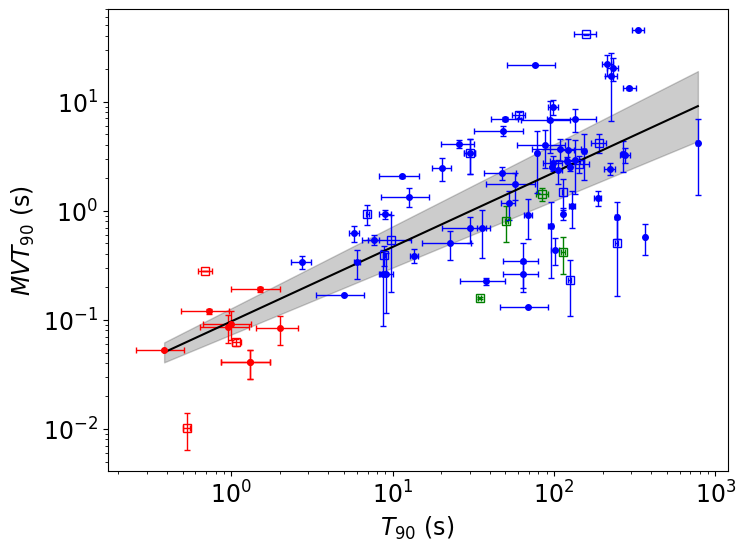

Gradient of the best fit line: 0.8959883293009676 +/- 0.08407116973462846
Correlation: 0.8266192672955127, p-value: 1.8187722815007907e-08


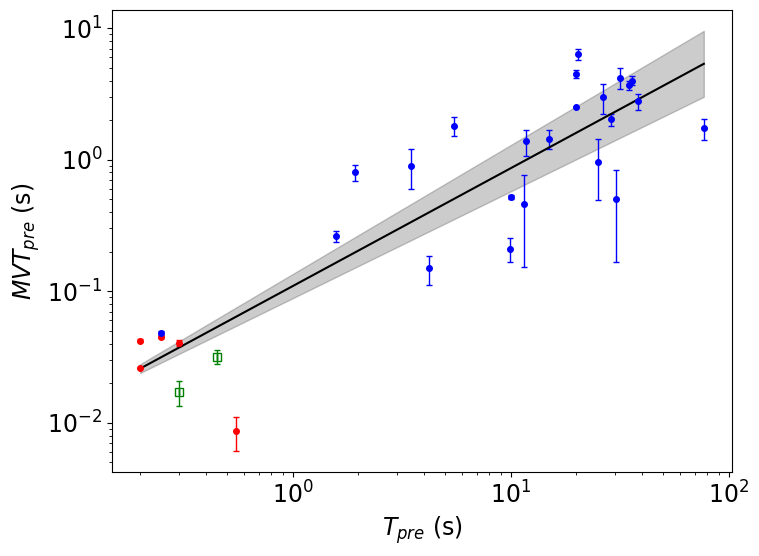

Gradient of the best fit line: 0.7452385474810933 +/- 0.1445279009594042
Correlation: 0.5915461624026696, p-value: 0.0005756552799210967


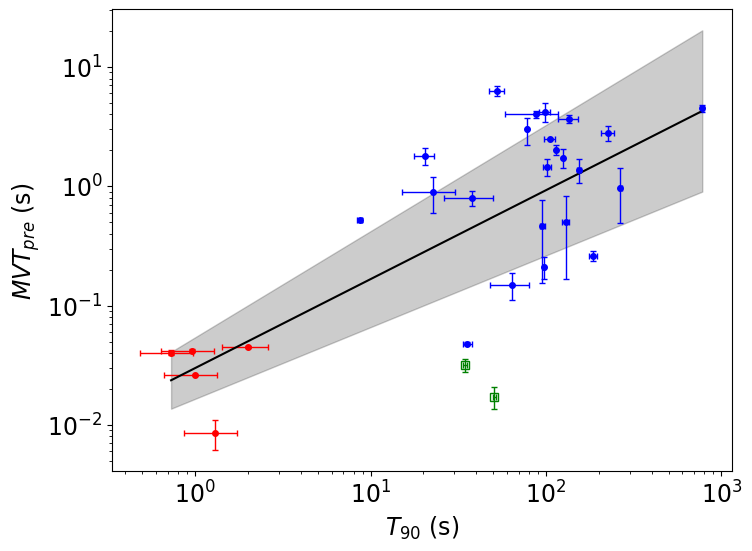

Gradient of the best fit line: 0.6105315142547789 +/- 0.09177215982275745
Correlation: 0.7810901001112347, p-value: 3.517777024987035e-07


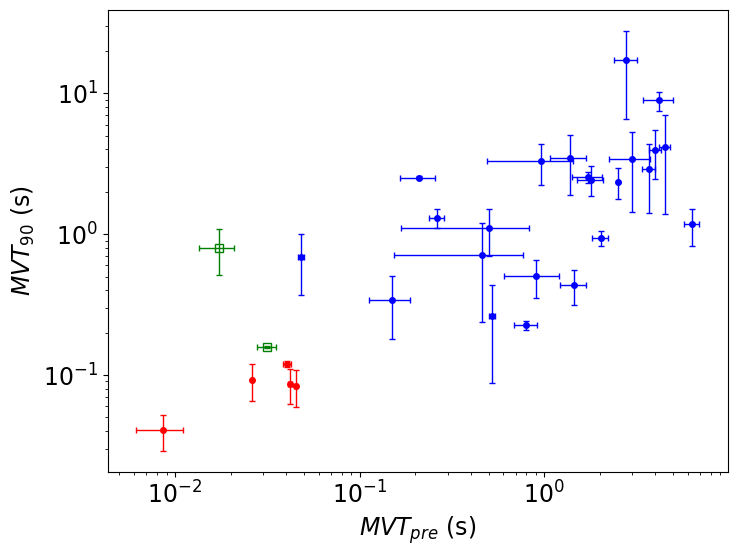

Gradient of the best fit line: 0.7580377686951935 +/- 0.11114498516578546
Correlation: 0.7481171687612469, p-value: 1.5633866602407457e-07


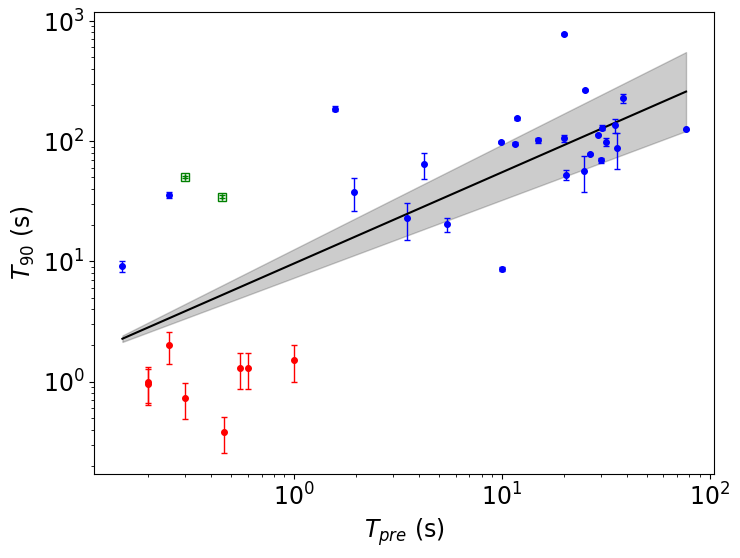

In [7]:
# add t90 errors 
hplotter(combined_MVT, 'T90_duration', 'T90_MVT', xerror='T90_duration_err', yerror='T90_MVT_err', log=True, best_fit=True)
hplotter(combined_MVT, 'Tpre_duration', 'Tpre_MVT', yerror='Tpre_MVT_err', log=True, best_fit=True)
hplotter(combined_MVT, 'T90_duration', 'Tpre_MVT', xerror='T90_duration_err', yerror='Tpre_MVT_err', log=True, best_fit=True)
hplotter(combined_MVT, 'Tpre_MVT', 'T90_MVT', xerror='Tpre_MVT_err', yerror='T90_MVT_err', log=True)
hplotter(combined_MVT, 'Tpre_duration', 'T90_duration', yerror='T90_duration_err', log=True, best_fit=True, save=False)

In [8]:
combined_MVT2 = combined_MVT.where(combined_MVT['T90_duration'] < 2)
df2 = combined_MVT2.sort_values(by='Tpre_duration', ascending=False)
df2

,GRB,T90_duration,T90_MVT,T90_MVT_err,Tpre_MVT,Tpre_MVT_err,Tpre_duration,T90_duration_err,Sample
3,GRB050724,1.500,0.189612,0.010354,NaN,NaN,1.000,0.500000,Troja
5,GRB090510,1.300,0.040575,0.011669,NaN,NaN,0.600,0.433333,Troja
6,GRB090510,1.300,0.040575,0.011669,0.008600,0.002476,0.550,0.433333,Troja
82,GRB130504B,0.384,0.052266,0.000202,NaN,NaN,0.464,0.128000,Coppin shorts
81,GRB100827A,0.728,0.119465,0.005728,0.040347,0.002069,0.300,0.242667,Coppin shorts
...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


//////////////////////////////////////////////////////////// KN ////////////////////////////////////////////////////////////


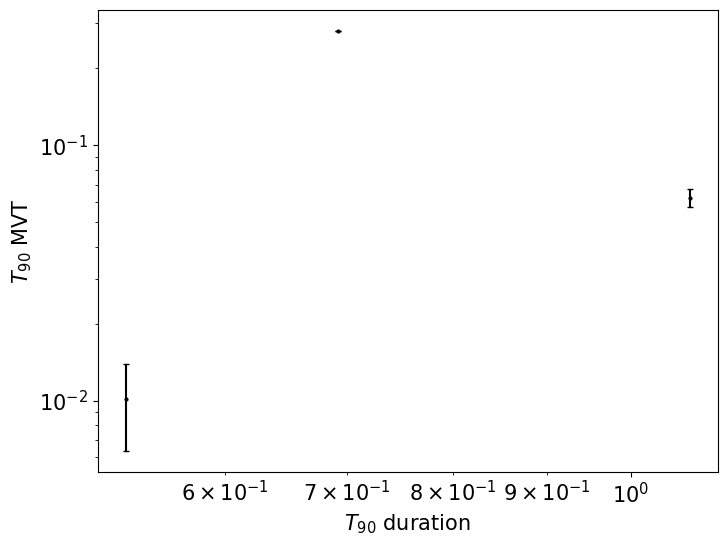

//////////////////////////////////////////////////////////// Troja ////////////////////////////////////////////////////////////


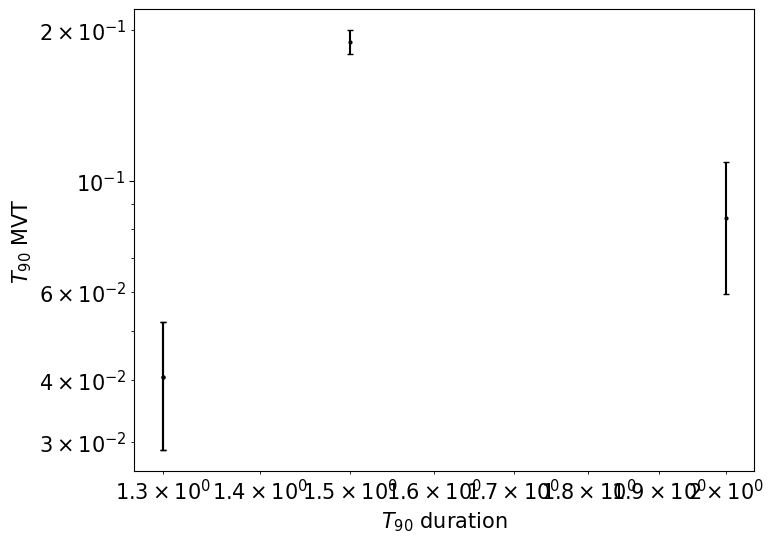

//////////////////////////////////////////////////////////// Golkhou ////////////////////////////////////////////////////////////


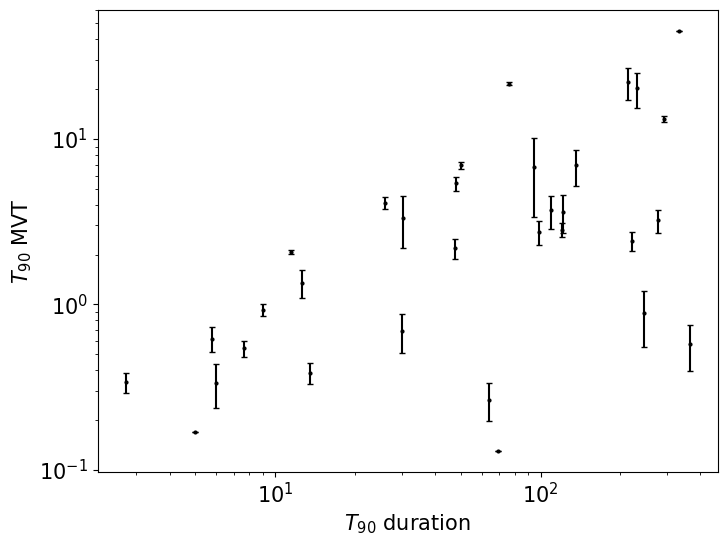

//////////////////////////////////////////////////////////// Anomalies ////////////////////////////////////////////////////////////


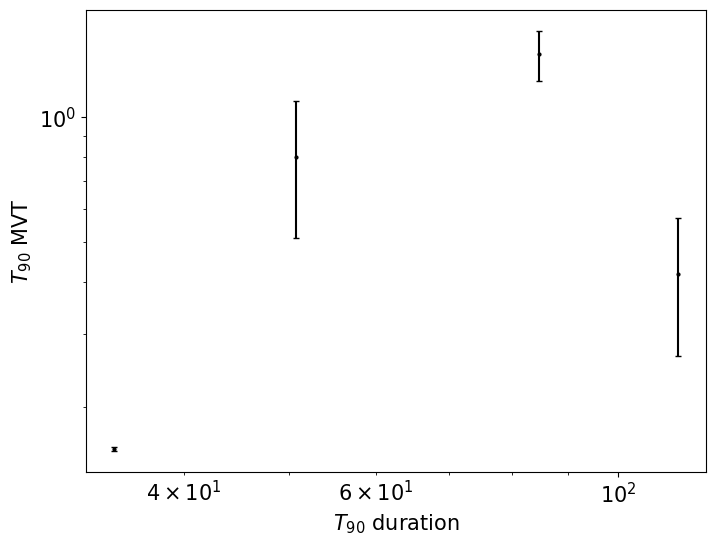

//////////////////////////////////////////////////////////// Cano ////////////////////////////////////////////////////////////


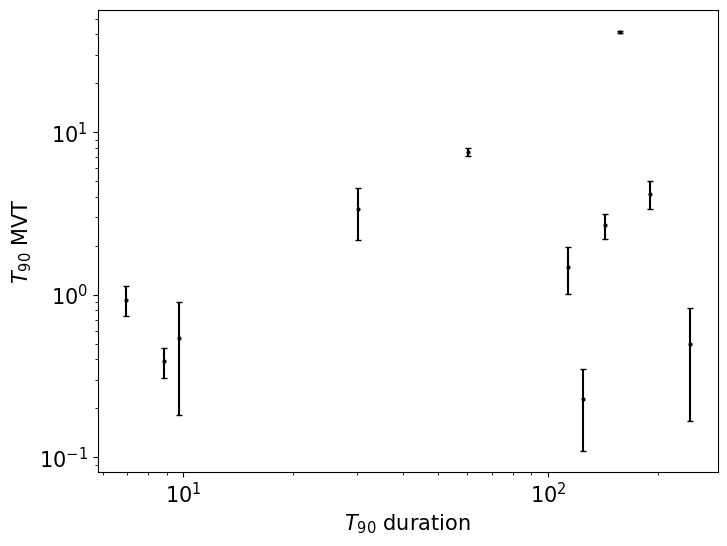

KeyError: 0

In [9]:
for mvtdf in MVT_DFs:

    print_banner(mvtdf['Sample'][0])
    plotter(mvtdf, 'T90_duration', 'T90_MVT', 'T90_MVT_err', log=True)


In [10]:
def add_prefix(name):
    if not name.startswith('GRB'):
        return 'GRB' + name
    return name

golk = pd.read_excel('Golkhou_results.xlsx')
golk['GRB'] = golk['GRB'].astype(str)
golk['GRB'] = golk['GRB'].apply(add_prefix)
golk_comb = pd.concat([combined_MVT, golk], ignore_index=True)

shared_df = combined_MVT.merge(golk, how='inner', on='GRB')

Gradient of the best fit line: 0.7762614512282925 +/- 0.16604013928930675
Correlation: 0.5780179324474642, p-value: 0.0003434647964904


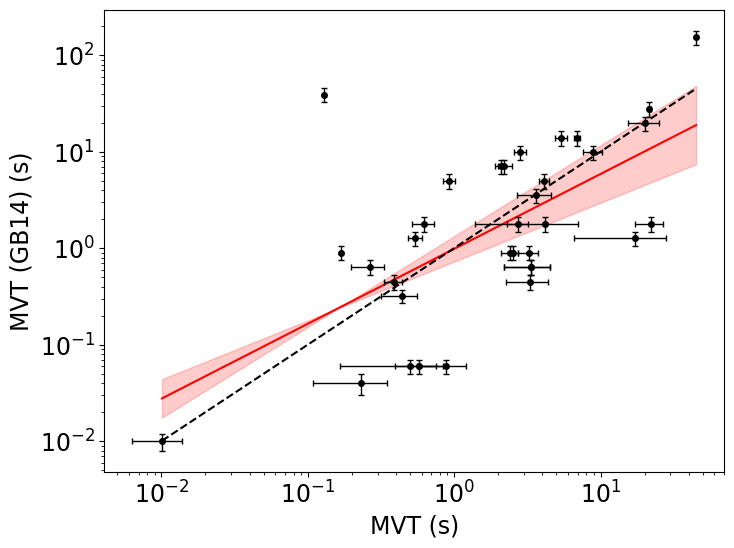

In [11]:
# Assuming 'df1' and 'df2' are your DataFrames and 'column_name' is the name of the column
shared = combined_MVT[combined_MVT['GRB'].isin(golk['GRB'])]
shared_df = combined_MVT.merge(golk, how='inner', on='GRB')

mpl.rcParams['font.size'] = 17
plt.figure(figsize=(8, 6))

x_axis = 'T90_MVT_x'
y_axis = 'T90_MVT_y'
xerror = 'T90_MVT_err_x'
yerror = 'T90_MVT_err_y'
log=True

def func(x, a, b):
    return a * x + b

df1 = shared_df[[x_axis, y_axis]].dropna()
x = np.log10(df1[x_axis]) if log else df1[x_axis]
y = np.log10(df1[y_axis]) if log else df1[y_axis]
popt, pcov = curve_fit(func, x, y)
correlation, p_value = spearmanr(df1[x_axis], df1[y_axis])
gradient_error = np.sqrt(np.diag(pcov))[0]
print(f"Gradient of the best fit line: {popt[0]} +/- {gradient_error}")
print(f'Correlation: {correlation}, p-value: {p_value}')

x_new = np.linspace(min(x), max(x), 10000)
line = func(x_new, *popt)
perr = np.sqrt(np.diag(pcov))
line_upper = func(x_new, *(popt + perr))
line_lower = func(x_new, *(popt - perr))
plt.plot(np.power(10, x_new), np.power(10, line), color='red', linestyle='-')
plt.fill_between(np.power(10, x_new), np.power(10, line_lower), np.power(10, line_upper), color='red', alpha=0.2)

plt.errorbar(shared_df[x_axis], shared_df[y_axis], xerr=(shared_df[xerror] if xerror is not None else 0), yerr=(shared_df[yerror] if yerror is not None else 0), marker='o', linestyle='', color='black', markersize=4, capsize=2, elinewidth=1)
plt.loglog([min(df1[x_axis]), max(df1[x_axis])], [min(df1[x_axis]), max(df1[x_axis])], color='black', linestyle='--')
plt.xlabel('MVT (s)')
plt.ylabel('MVT (GB14) (s)')
plt.xscale('log')
plt.yscale('log')

# plt.savefig('relevant plots/golkMVT_vs_myMVT.png', dpi=900, bbox_inches='tight')
plt.show()

In [10]:
def add_prefix(name):
    if name.startswith('GRB'):
        return name[3:]
    elif name.startswith('bn'):
        return name[2:]
    else:
        return name 
    
tab = pd.read_csv('../GRBweb_table.txt', sep='\s+')
pret = pd.read_csv('../Precursor_table.txt', sep='\s+')

tab['GRB_name_Fermi'] = tab['GRB_name_Fermi'].astype(str)
pret['GRB_name_Fermi'] = pret['GRB_name_Fermi'].astype(str)
tab['GRB_name_Fermi'] = tab['GRB_name_Fermi'].apply(add_prefix)
pret['GRB_name_Fermi'] = pret['GRB_name_Fermi'].apply(add_prefix)
coppin_df = pret.merge(tab, on='GRB_name_Fermi', how='inner', suffixes=('_pre', '_tab'))
coppin_df['Sample'] = 'Coppin'
coppin_df = coppin_df.rename(columns={'T90': 'T90_duration', 'duration': 'Tpre_duration', 'GRB_name_pre': 'GRB'})

coppin_df = coppin_df[['GRB', 'Sample', 'T90_duration', 'Tpre_duration', 'T90_error']]
coppin_df

,GRB,Sample,T90_duration,Tpre_duration,T90_error
0,GRB080723B,Coppin,58.369,28.319,1.985
1,GRB080807A,Coppin,19.072,1.032,0.181
2,GRB080816A,Coppin,64.769,1.823,1.810
3,GRB080818A,Coppin,59.329,5.596,8.749
4,GRB080830A,Coppin,40.897,5.112,5.069
...,...,...,...,...,...
239,GRB191026A,Coppin,59.136,4.110,4.944
240,GRB191031A,Coppin,200.196,10.422,3.338
241,GRB191101B,Coppin,10.496,1.903,1.086
242,GRB191111A,Coppin,88.066,16.425,0.923


In [29]:
cop_df = coppin_df[['GRB', 'T90_duration', 'Tpre_duration']]
cop_df['Type'] = np.where(cop_df['T90_duration'] > 2, 'long', 'short')
cop_df = cop_df.sort_values(by='Tpre_duration').reset_index(drop=True)
cop_df.to_excel('Tpre_T90_coppin.xlsx', index=False)

/var/folders/x8/932d6tp518jf_vxj6p6529k40000gn/T/ipykernel_1923/4245415481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cop_df['Type'] = np.where(cop_df['T90_duration'] > 2, 'long', 'short')


In [13]:
comb = combined_MVT[['GRB', 'T90_duration', 'Tpre_duration', 'Sample']]
full_comb = coppin_df.merge(combined_MVT, on=['GRB'], how='outer', suffixes=('_df1', '_df2'))
full_comb['Sample'] = full_comb['Sample_df2'].combine_first(full_comb['Sample_df1'])
full_comb['T90_duration'] = full_comb['T90_duration_df1'].combine_first(full_comb['T90_duration_df2'])
full_comb['Tpre_duration'] = full_comb['Tpre_duration_df1'].combine_first(full_comb['Tpre_duration_df2'])
full_comb = full_comb.drop(columns=['Sample_df1', 'Sample_df2', 'T90_duration_df1', 'T90_duration_df2', 'Tpre_duration_df1', 'Tpre_duration_df2'])

In [14]:
def hplotter2(df, x_axis, y_axis, xerror=None, yerror=None, log=False, best_fit=False, save=False):

    def func(x, a, b):
        return a * x + b

    df1 = df[[x_axis, y_axis]].dropna()
    x = np.log10(df1[x_axis]) if log else df1[x_axis]
    y = np.log10(df1[y_axis]) if log else df1[y_axis]
    popt, pcov = curve_fit(func, x, y)
    correlation, p_value = spearmanr(df1[x_axis], df1[y_axis])
    gradient_error = np.sqrt(np.diag(pcov))[0]
    print(f"Gradient of the best fit line: {popt[0]} +/- {gradient_error}")
    print(f'Correlation: {correlation}, p-value: {p_value}')

    coppin_short = df[(df['Sample'] == 'Coppin') & (df['T90_duration'] <= 2)]
    coppin_long = df[(df['Sample'] == 'Coppin') & (df['T90_duration'] > 2)]
    df = df[(df['Sample'] != 'Coppin')]
    defo_short_df  = df[(df['Sample'] == 'KN')]
    anoms_df  = df[(df['Sample'] == 'Anomalies')]
    t_shorts_df = df[(df['Sample'] != 'KN') & (df['Sample'] != 'Anomalies') & (df['T90_duration'] <= 2)]
    defo_longs_df = df[(df['Sample'] == 'Cano')]
    t_longs_df = df[(df['Sample'] != 'Cano') & (df['Sample'] != 'Anomalies') & (df['T90_duration'] > 2)]

    mrksz = 6
    mpl.rcParams['font.size'] = 17
    plt.figure(figsize=(8, 6))
    alpha = 0.2
    plt.errorbar(coppin_short[x_axis], coppin_short[y_axis], xerr=(coppin_short[xerror] if xerror is not None else None), yerr=(None if yerror is not None else None), marker='o', linestyle='', color='red', markersize=5, capsize=2, elinewidth=1, alpha=alpha,  ecolor=(1, 0, 0, alpha), markeredgewidth=0)
    plt.errorbar(coppin_long[x_axis], coppin_long[y_axis], xerr=(coppin_long[xerror] if xerror is not None else None), yerr=(None if yerror is not None else None), marker='o', linestyle='', color='blue', markersize=5, capsize=2, elinewidth=1, alpha=alpha,  ecolor=(0, 0, 1, alpha), markeredgewidth=0)
    plt.errorbar(defo_short_df[x_axis], defo_short_df[y_axis], xerr=(defo_short_df[xerror] if xerror is not None else 0), yerr=(defo_short_df[yerror] if yerror is not None else 0), marker='s', linestyle='', color='red', markersize=mrksz, capsize=2, markerfacecolor='none', elinewidth=1)
    plt.errorbar(anoms_df[x_axis], anoms_df[y_axis], xerr=(anoms_df[xerror] if xerror is not None else 0), yerr=(anoms_df[yerror] if yerror is not None else 0), marker='s', linestyle='', color='green', markersize=mrksz, capsize=(2 if (yerror is not None or xerror is not None) else 0), markerfacecolor='none', elinewidth=1)
    plt.errorbar(t_shorts_df[x_axis], t_shorts_df[y_axis], xerr=(t_shorts_df[xerror] if xerror is not None else 0), yerr=(t_shorts_df[yerror] if yerror is not None else 0), marker='o', linestyle='', color='red', markersize=4, capsize=2, elinewidth=1)
    plt.errorbar(defo_longs_df[x_axis], defo_longs_df[y_axis], xerr=(defo_longs_df[xerror] if xerror is not None else 0), yerr=(defo_longs_df[yerror] if yerror is not None else 0), marker='s', linestyle='', color='blue', markersize=mrksz, capsize=2, markerfacecolor='none', elinewidth=1)
    plt.errorbar(t_longs_df[x_axis], t_longs_df[y_axis], xerr=(t_longs_df[xerror] if xerror is not None else 0), yerr=(t_longs_df[yerror] if yerror is not None else 0), marker='o', linestyle='', color='blue', markersize=4, capsize=2, elinewidth=1)


    plt.xlabel(name_dict[x_axis])
    plt.ylabel(name_dict[y_axis])

    if log:
        plt.xscale('log')
        plt.yscale('log')

    if log and best_fit:
        x_new = np.linspace(min(x), max(x), 10000)
        line = func(x_new, *popt)
        perr = np.sqrt(np.diag(pcov))
        line_upper = func(x_new, *(popt + perr))
        line_lower = func(x_new, *(popt - perr))
        plt.plot(np.power(10, x_new), np.power(10, line), color='black', linestyle='-')
        plt.fill_between(np.power(10, x_new), np.power(10, line_lower), np.power(10, line_upper), color='black', alpha=0.2)

    if save:
        plt.savefig('relevant plots/%s_vs_%s.png' % (x_axis, y_axis), dpi=900, bbox_inches='tight')

    plt.show()

Gradient of the best fit line: 0.39626475295437247 +/- 0.03872433835251905
Correlation: 0.547219228269895, p-value: 1.8431991212893934e-20


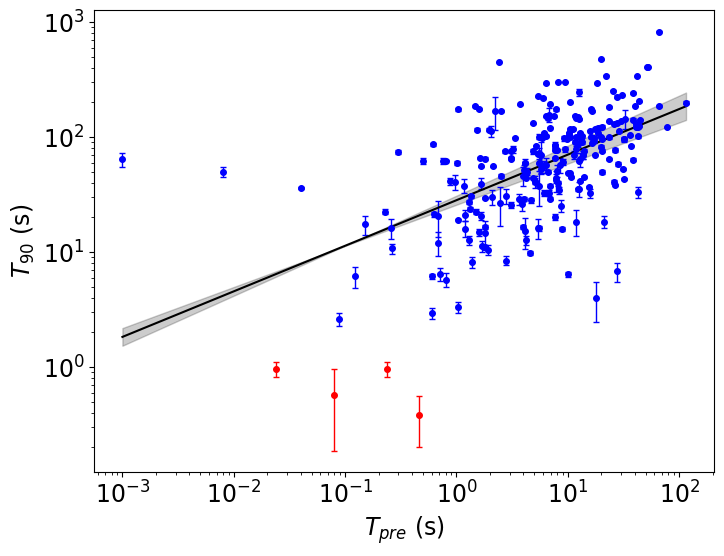

Gradient of the best fit line: 0.43981877815432024 +/- 0.039041076848824754
Correlation: 0.578079056672488, p-value: 5.861211315097644e-24


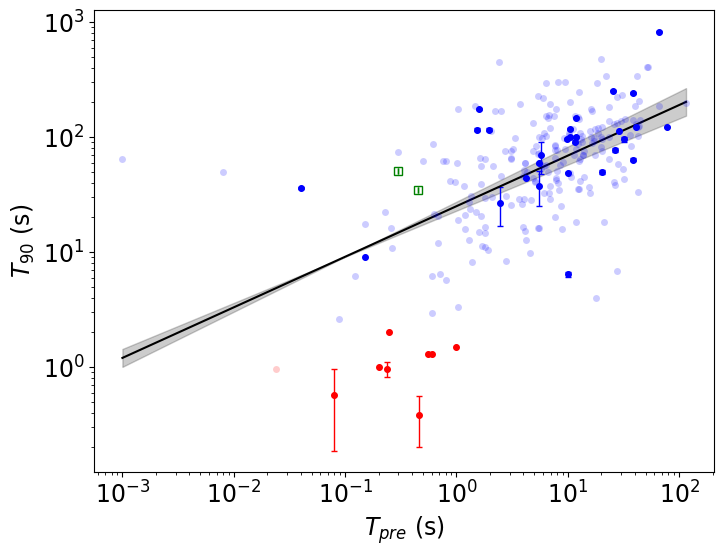

In [15]:
hplotter(coppin_df, 'Tpre_duration', 'T90_duration', xerror=None, yerror='T90_error', log=True, best_fit=True)
hplotter2(full_comb, 'Tpre_duration', 'T90_duration', xerror=None, yerror='T90_error', log=True, best_fit=True, save=False)